<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1086 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 33.22 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f45742b2fb0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

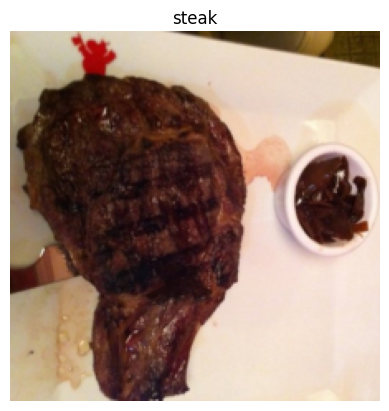

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [10]:
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

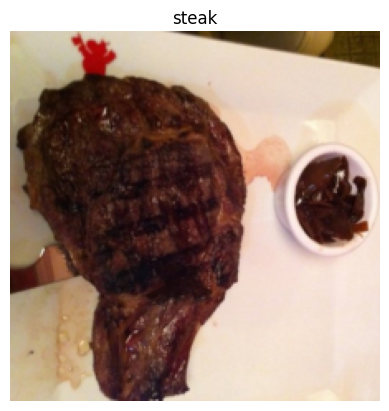

In [12]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

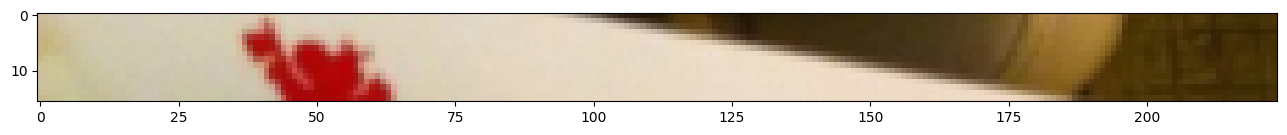

In [13]:
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


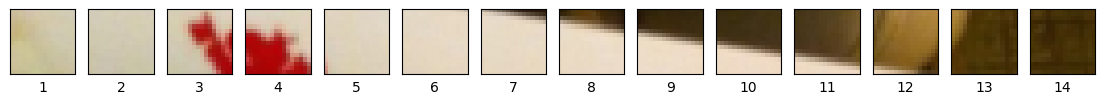

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


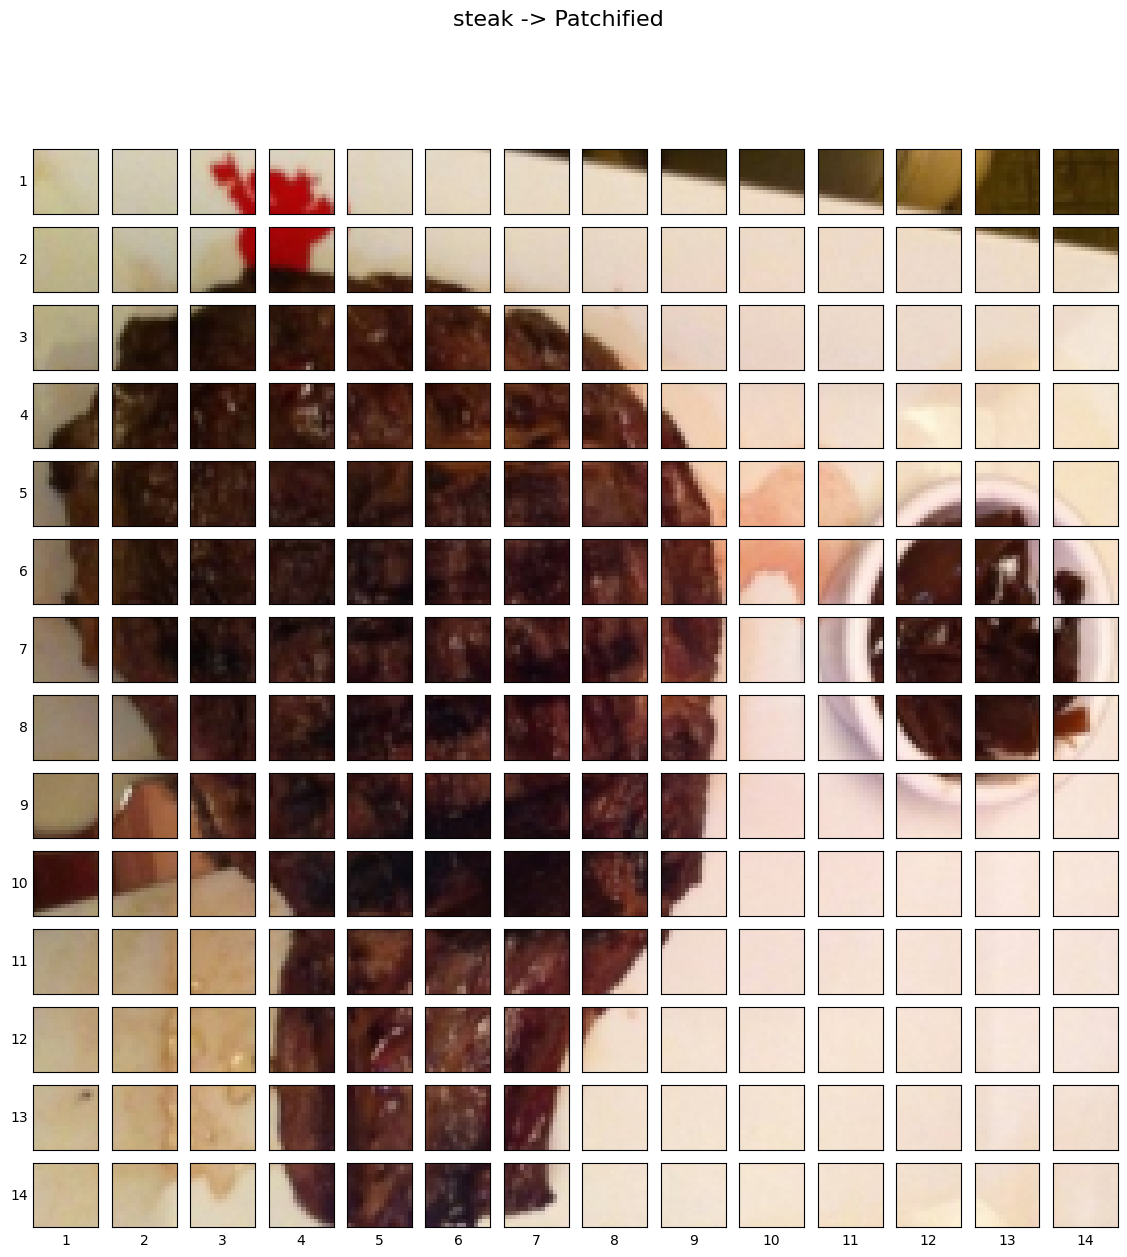

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

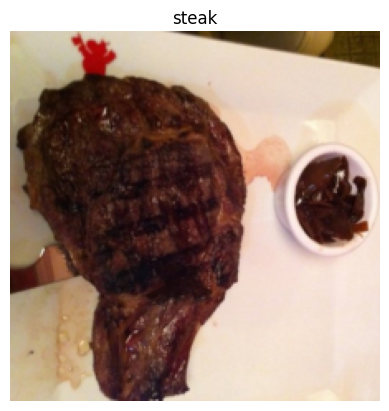

In [17]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image.shape)
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [529, 712, 298, 37, 703]


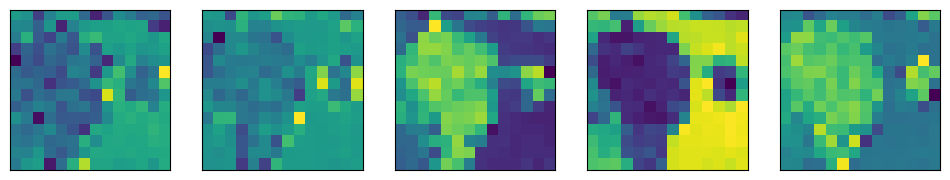

In [19]:
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2804, -0.2929, -0.4849, -0.2197, -0.2940, -0.2975, -0.2874,
           -0.0499, -0.0368,  0.1238, -0.0427, -0.3142, -0.2486, -0.1603],
          [-0.3033, -0.2988, -0.3180, -0.1049, -0.4441, -0.3310, -0.2904,
           -0.2744, -0.2790, -0.2814, -0.2753, -0.3187, -0.2175, -0.0533],
          [-0.2882, -0.1932, -0.0923, -0.0702, -0.0532, -0.0402, -0.2023,
           -0.3010, -0.2569, -0.2628, -0.2676, -0.2893, -0.2990, -0.2731],
          [-0.3374, -0.0817, -0.0033, -0.0557, -0.0640, -0.0532, -0.0569,
           -0.1234, -0.2774, -0.2837, -0.2670, -0.2889, -0.2868, -0.3008],
          [-0.2025, -0.0516, -0.0523, -0.0254, -0.0794,  0.0013, -0.0417,
           -0.0738, -0.1494, -0.2915, -0.2726, -0.4720, -0.4194, -0.3198],
          [-0.2432, -0.0893, -0.0734, -0.0311, -0.0590, -0.0385, -0.0181,
           -0.0443, -0.0241, -0.2565, -0.2480, -0.1587,  0.0666, -0.0931],
          [-0.1738, -0.0075, -0.0507, -0.0476, -0.0021, -0.0216, -0.0620,
           -0.0520,  0.0553, -0.

In [22]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [24]:
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

In [25]:
image.unsqueeze(0)

tensor([[[[0.7961, 0.8078, 0.8118,  ..., 0.2745, 0.2824, 0.2980],
          [0.7922, 0.7961, 0.8118,  ..., 0.2784, 0.2863, 0.3020],
          [0.7922, 0.7922, 0.8000,  ..., 0.2706, 0.2824, 0.2824],
          ...,
          [0.8314, 0.8196, 0.8235,  ..., 0.9333, 0.9255, 0.9294],
          [0.8235, 0.8235, 0.8157,  ..., 0.9216, 0.9216, 0.9255],
          [0.8039, 0.8118, 0.8118,  ..., 0.9137, 0.9216, 0.9216]],

         [[0.7373, 0.7490, 0.7529,  ..., 0.1961, 0.1922, 0.1961],
          [0.7333, 0.7373, 0.7529,  ..., 0.2000, 0.1961, 0.2078],
          [0.7255, 0.7294, 0.7451,  ..., 0.1922, 0.1922, 0.1882],
          ...,
          [0.7569, 0.7451, 0.7451,  ..., 0.8667, 0.8588, 0.8588],
          [0.7490, 0.7451, 0.7373,  ..., 0.8549, 0.8549, 0.8549],
          [0.7294, 0.7333, 0.7333,  ..., 0.8471, 0.8549, 0.8510]],

         [[0.6196, 0.6196, 0.6275,  ..., 0.0314, 0.0235, 0.0235],
          [0.6039, 0.6000, 0.6196,  ..., 0.0431, 0.0314, 0.0392],
          [0.5922, 0.5804, 0.5843,  ..., 0

In [26]:
patch_embedded_image = patchify(image.unsqueeze(0))

In [27]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [28]:
image.shape[-1]

224

In [29]:
224/ 16

14.0

In [30]:
16 * 16 * 3

768

In [31]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

In [32]:
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [33]:
print(patch_embedded_image.shape)


torch.Size([1, 196, 768])


In [34]:
batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]

In [35]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimensions,
                                      requires_grad=True))

In [36]:
print(class_token[:, :, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [37]:
class_token.shape

torch.Size([1, 1, 768])

In [38]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

In [39]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [40]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8056,  0.2118, -0.2084,  ...,  0.5811, -0.3635,  0.2901],
         [-0.8218,  0.2093, -0.2076,  ...,  0.6080, -0.3897,  0.2921],
         ...,
         [-0.9422,  0.2269, -0.2299,  ...,  0.7027, -0.4416,  0.3424],
         [-0.9361,  0.2129, -0.2309,  ...,  0.6656, -0.4430,  0.3632],
         [-0.9219,  0.2208, -0.2491,  ...,  0.6786, -0.4301,  0.3366]]],
       grad_fn=<CatBackward0>)

In [41]:
16**2 * 3

768

In [42]:
number_of_patches

196

In [43]:
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
embedding_dimension

768

In [44]:
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

In [45]:
print(position_embedding[:, :10, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [46]:
position_embedding.shape

torch.Size([1, 197, 768])

In [47]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1944, 1.2118, 0.7916,  ..., 1.5811, 0.6365, 1.2901],
         [0.1782, 1.2093, 0.7924,  ..., 1.6080, 0.6103, 1.2921],
         ...,
         [0.0578, 1.2269, 0.7701,  ..., 1.7027, 0.5584, 1.3424],
         [0.0639, 1.2129, 0.7691,  ..., 1.6656, 0.5570, 1.3632],
         [0.0781, 1.2208, 0.7509,  ..., 1.6786, 0.5699, 1.3366]]],
       grad_fn=<AddBackward0>)


In [48]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [49]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [50]:
# Summary

set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,
                                      embedding_dimensions),
                                      requires_grad = True)
print(class_token.shape)

patch_embedding_class_token = torch.cat((class_token, patch_embedded_image), dim = 1)
print(patch_embedding_class_token.shape)


number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [51]:
class MultiheadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)

    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [52]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(patch_and_position_embedding.shape)
print(patched_image_through_msa_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [53]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
               nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
               nn.GELU(),
               nn.Dropout(p=dropout),
               nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
               nn.Dropout(p=dropout)
               )

  def forward(self, x):
      x = self.layer_norm(x)
      x = self.mlp(x)
      return x

In [54]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [55]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
                embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                num_heads:int=12, # Heads from Table 1 for ViT-Base
                mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                attn_dropout:float=0):

    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x

    x = self.mlp_block(x) + x

    return x



In [56]:
transformer_encoder_block = TransformerEncoderBlock()


In [57]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [58]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [59]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [67]:
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Training resolution from Table 3 in ViT paper
               in_channels:int=3, # Number of channels in input image
               patch_size:int=16, # Patch size
               num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0, # Dropout for attention projection
               mlp_dropout:float=0.1, # Dropout for dense/MLP layers
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000):

    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (img_size * img_size) // patch_size**2

    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dimensions),
                                      requires_grad=True)


    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)


    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


    self.classifier = nn.Sequential(
                                    nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim,
                                              out_features=num_classes)
                                    )

  def forward(self, x):

      batch_size = x.shape[0]
      class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)
      x = self.patch_embedding(x)
      x = torch.cat((class_token, x), dim=1)

      # 16. Add position embedding to patch embedding (equation 1)
      x = self.position_embedding + x

      # 17. Run embedding dropout (Appendix B.1)
      x = self.embedding_dropout(x)

      # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
      x = self.transformer_encoder(x)

      # 19. Put 0 index logit through classifier (equation 4)
      x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

      return x

In [68]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [69]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [70]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [61]:
Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb

SyntaxError: ignored